In [0]:
from google.colab import files
files.upload()

In [0]:
import numpy as np 
import pandas as pd 
from scipy import stats as ss
import statsmodels.api as sm
import sklearn.metrics as ssm
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest

import os
df = pd.read_csv("UPHFinal_2.csv")

In [0]:
print('variables: ' + str(df.columns))

variables: Index(['Unnamed: 0', 'AppointmentID', 'PatientID', 'ClinicNM',
       'AppointmentDTS', 'AppointmentMonthNBR', 'AppointmentWeekdayNBR',
       'AppointmentHourNBR', 'AgeNBR', 'SexFLG', 'HispanicFLG', 'SingleFLG',
       'LivesInApartmentFLG', 'EmailFLG', 'ApptLagNBR', 'InsuranceDSC',
       'HypertensionFLG', 'AsthmaFLG', 'HeartDiseaseFLG', 'ObeseFLG',
       'DiabetesFLG', 'Noshow24NBR', 'CancellationsNBR', 'Latearrivals24NBR',
       'CheckintoCheckoutNBR', 'AppttoCheckoutNBR', 'CheckintoApptNBR',
       'Arrived24NBR', 'Providers24CNT', 'ThatProvider24NBR',
       'NoshowRate24NBR', 'EdVisitsNBR', 'IpVisitsNBR', 'NoShowFLG',
       'CancelledLateFLG', 'NewPatient', 'Cost', 'Rand', 'Revenue', 'Profit',
       'Age_bin', 'ClinicNM_num', 'SexFLG_num', 'InsuranceDSC_num',
       'Noshow24NBR_Bin', 'CheckintoCheckoutNBR_Bin', 'CheckintoApptNBR_bin',
       'Arrived24NBR_bin', 'Providers24CNT_bin', 'ThatProvider24NBR_bin',
       'NoshowRate24NBR_bin', 'CancellationsNBR_Bin', '

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95221 entries, 0 to 95220
Data columns (total 54 columns):
Unnamed: 0                  95221 non-null int64
AppointmentID               95221 non-null int64
PatientID                   95221 non-null int64
ClinicNM                    95221 non-null object
AppointmentDTS              95221 non-null object
AppointmentMonthNBR         95221 non-null int64
AppointmentWeekdayNBR       95221 non-null int64
AppointmentHourNBR          95221 non-null int64
AgeNBR                      95221 non-null int64
SexFLG                      95221 non-null object
HispanicFLG                 95221 non-null int64
SingleFLG                   95221 non-null int64
LivesInApartmentFLG         95221 non-null int64
EmailFLG                    95221 non-null int64
ApptLagNBR                  95221 non-null int64
InsuranceDSC                95221 non-null object
HypertensionFLG             95221 non-null int64
AsthmaFLG                   95221 non-null int64
Heart

In [0]:
df.shape

(95221, 54)

1. Univariate Analysis

a) PatientId

To build new features related to the apointment, is necessary to check how many patients there are, and how much appointments per patient there is. But first, let's check the variable type.

In [0]:
print('Total appointments: ' + format(df.shape[0], ",d"))
print('Distinct patients: ' + format(df['PatientID'].unique().shape[0], ",d"))

Total appointments: 95,221
Distinct patients: 33,473


In [0]:
print('Patients with more than one appointment: ' + format((df['PatientID'].value_counts() > 1).sum(), ",d"))

Patients with more than one appointment: 20,942


Nearly 60% of patients have more than one appointment. It's enough to justify the creation of the new variable: number of previous appointments booked and no-show rate based on previous appointments.**bold text**

In [0]:
df['PreviousApp'] = df.sort_values(by = ['PatientID','AppointmentDTS']).groupby(['PatientID']).cumcount()

In [0]:
a = df.groupby(pd.cut(df.PreviousApp, bins = [-1, 0,1,2,3,4,5, 85], include_lowest = True))[['PreviousApp']].count()
b = pd.DataFrame(a)
b.set_index(pd.Series(['0', '1', '2', '3', '4', '5', '> 5']))

,PreviousApp
0,33473
1,20942
2,13329
3,8734
4,5716
5,3788
> 5,9239


We need to build the rate of previous no-show per patients, for those with more than 1 PreviousApp.

In [0]:
df['NoShowFLG'] = (df['NoShowFLG'] == 1 )*1
df['PreviousNoShow'] = (df[df['PreviousApp'] > 0].sort_values(['PatientID', 'AppointmentDTS']).groupby(['PatientID'])['NoShowFLG'].cumsum() / df[df['PreviousApp'] > 0]['PreviousApp'])

In [0]:
df['PreviousNoShow'].describe()

count    61748.000000
mean         0.092094
std          0.222620
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: PreviousNoShow, dtype: float64

More than half of people with previous appointment have gone to all the appointments scheduled. Later on we'll study if this variable is important to predict No-Show, even though it has lots of missings.


b) Gender

In [0]:
df['SexFLG'].value_counts()

F    57070
M    38151
Name: SexFLG, dtype: int64

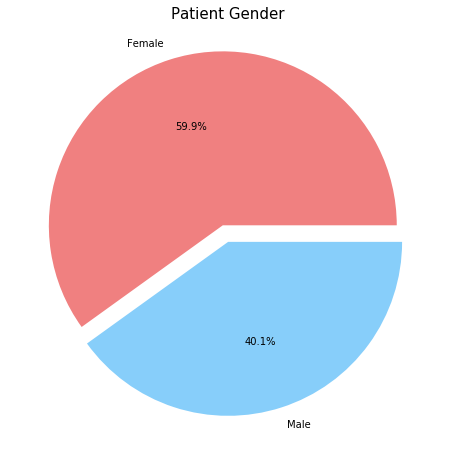

In [0]:
colors = ['lightcoral', 'lightskyblue']

plt.pie([57070, 38151], explode = (0.1, 0), labels = ['Female', 'Male'], colors = colors, autopct='%1.1f%%') 

plt.title('Patient Gender', fontsize=15)
plt.gcf().set_size_inches(8, 8)
plt.show()

We can see that almost two thirds of the appointments are done by women, a number much higher than men. There are no missing nor atypical values.

c) ScheduledDay

First we must change the variable type to DateTime.

In [0]:
df['AppointmentDTS'] = pd.to_datetime(df['AppointmentDTS'])
df['AppointmentDTS2'] = df.apply(lambda x: x.AppointmentDTS.strftime("%x"), axis = 1)
AppointmentDTS = df.groupby(['AppointmentDTS2'])[['AppointmentDTS']].count()

In [0]:
AppointmentDTS.reset_index(inplace = True)
AppointmentDTS.columns = ['Date', 'Count']

In [0]:
AppointmentDTS['Date'] = pd.to_datetime(AppointmentDTS['Date'])

In [0]:
print('first appointment date: ' + str(AppointmentDTS.Date.min()))
print('most appointment date: ' + str(AppointmentDTS.Date.max()))

first appointment date: 2018-01-13 00:00:00
most appointment date: 2018-12-28 00:00:00


In [0]:
df['WeekdayScheduled'] = df.apply(lambda x: x.AppointmentDTS.isoweekday(), axis = 1)
df['WeekdayScheduled'].value_counts()


3    19983
4    19936
2    19711
1    18196
5    16929
6      429
7       37
Name: WeekdayScheduled, dtype: int64

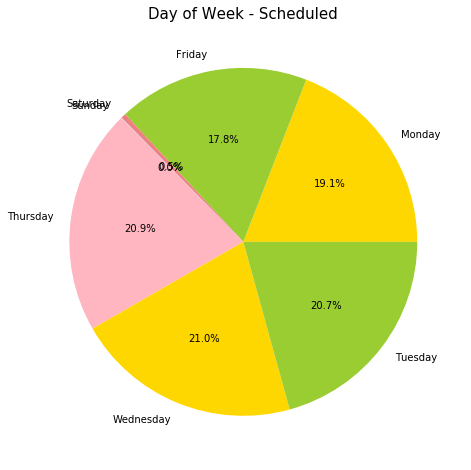

In [0]:
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightpink']

plt.pie([df['WeekdayScheduled'].value_counts()[1], df['WeekdayScheduled'].value_counts()[5], df['WeekdayScheduled'].value_counts()[6],df['WeekdayScheduled'].value_counts()[7],
         df['WeekdayScheduled'].value_counts()[4], df['WeekdayScheduled'].value_counts()[3], df['WeekdayScheduled'].value_counts()[2]], 
        labels = ['Monday','Friday','Saturday','Sunday','Thursday','Wednesday' ,'Tuesday'], 
        colors = colors, autopct='%1.1f%%') 

plt.title('Day of Week - Scheduled', fontsize=15)
plt.gcf().set_size_inches(8, 8)
plt.show()

d) Age

In [0]:
df['AgeNBR'].describe()

count    95221.000000
mean        44.532792
std         22.984130
min          0.000000
25%         27.000000
50%         46.000000
75%         62.000000
max        118.000000
Name: AgeNBR, dtype: float64

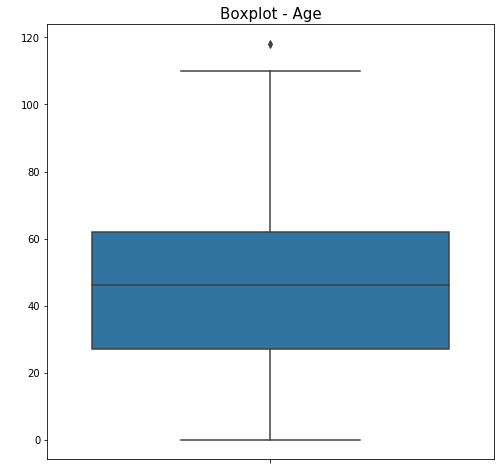

In [0]:
ax = sns.boxplot(x=df['AgeNBR'], orient = 'v')

#plt.xlabel(' ')
plt.ylabel(' ')
plt.title('Boxplot - Age', fontsize = 15)
plt.gcf().set_size_inches(8, 8)
plt.show()

In [0]:
df['ClinicNM'].value_counts() 

B    29990
A    26370
E    15084
C    14480
D     9297
Name: ClinicNM, dtype: int64

Additional Features:

e) PreviousDisease

This variable will summarize all patients with some disease diagnosed: hypertension, diabetes or alcoholism.

In [0]:
df['PreviousDisease'] = df.apply(lambda x: ((x.HypertensionFLG == 1 )| x.AsthmaFLG == 1 | x.HeartDiseaseFLG == 1 | x.ObeseFLG == 1 | x.DiabetesFLG == 1)*1, axis = 1)

In [0]:
df['PreviousDisease'].value_counts()

0    56271
1    38950
Name: PreviousDisease, dtype: int64

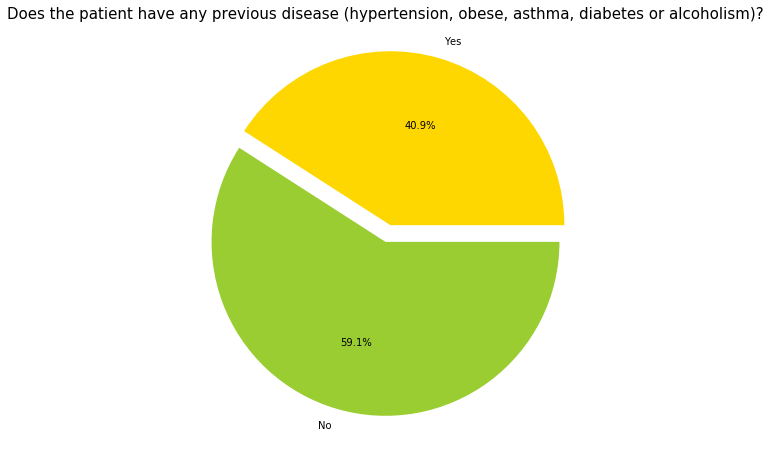

In [0]:
plt.pie([df['PreviousDisease'].value_counts()[1] ,df['PreviousDisease'].value_counts()[0] ], 
        explode = (0.1, 0), labels = ['Yes', 'No'], colors = colors, autopct='%1.1f%%') 

plt.title('Does the patient have any previous disease (hypertension, obese, asthma, diabetes or alcoholism)?', fontsize=15)
plt.gcf().set_size_inches(8, 8)
plt.show()

The reason to create this variable is to check if patients with diseases (no matter which) have similar behavior regarding medical appointment no-show.

f) DaysBeforeApp

Indicates the number of days between scheduled day and appointment day

In [0]:

df['DaysBeforeApp'] = df['ApptLagNBR']

In [0]:
df['DaysBeforeApp'].value_counts()

0      22713
1       7550
7       4038
2       3491
3       3439
4       2886
6       2794
14      2644
8       2447
5       2409
21      1814
28      1757
9       1716
15      1665
13      1506
10      1389
16      1245
11      1240
12      1152
20      1110
22      1105
35      1097
17      1081
29       899
19       859
18       859
30       824
23       807
91       771
27       761
       ...  
234        1
399        1
546        1
205        1
235        1
299        1
384        1
269        1
207        1
259        1
241        1
354        1
274        1
215        1
244        1
309        1
276        1
377        1
379        1
374        1
220        1
328        1
348        1
273        1
306        1
209        1
242        1
223        1
267        1
282        1
Name: DaysBeforeApp, Length: 273, dtype: int64

Most of appointments where scheduled less than one day in advance. 

In [0]:
days_before = df.groupby(['DaysBeforeApp'])[['NoShowFLG']].count()
days_before.reset_index(inplace = True)
days_before.columns = ['Days Ahead', 'Count']

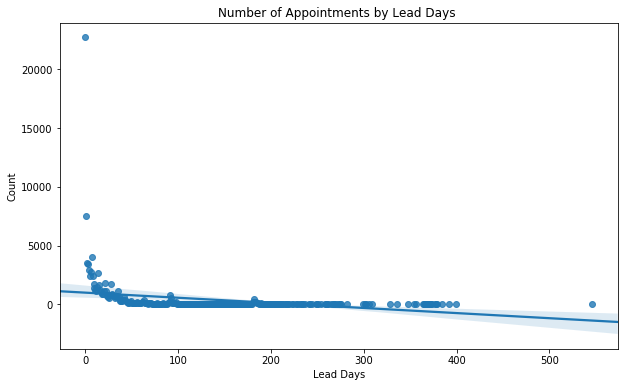

In [0]:
sns.regplot(x = 'Days Ahead', y = 'Count', data = days_before)
plt.title('Number of Appointments by Lead Days ')
plt.xlabel('Lead Days')
#plt.xlim('2016-04-28', '2016-06-09')
plt.gcf().set_size_inches(10, 6)
plt.show()

Most appointments are scheduled less than a day in advance. We will categorize this variable to group similar situations (this will implicate that, for the model, one hot encoding will be necessary in order to use the categorized variable).

In [0]:
def DaysBeforeCat(days):
    if days == 0:
        return '0 days'
    elif days in range(1,3):
        return '1-2 days'
    elif days in range(3,8):
        return '3-7 days'
    elif days in range(8, 32):
        return '8-31 days'
    else:
        return '> 31 days'
    
df['DaysBeforeCat'] = df.DaysBeforeApp.apply(DaysBeforeCat)


In [0]:
df['DaysBeforeCat'].value_counts()

8-31 days    29516
0 days       22713
> 31 days    16385
3-7 days     15566
1-2 days     11041
Name: DaysBeforeCat, dtype: int64

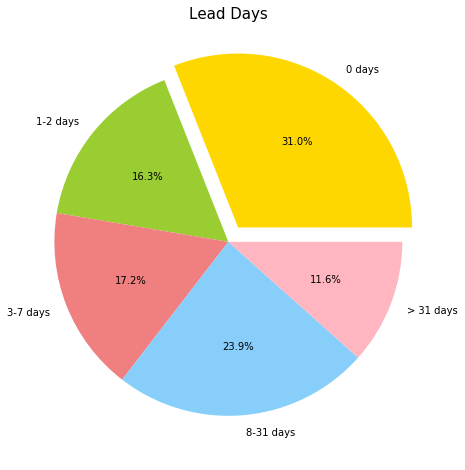

In [0]:
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightpink']

plt.pie([df['DaysBeforeCat'].value_counts()[0], df['DaysBeforeCat'].value_counts()[3], 
         df['DaysBeforeCat'].value_counts()[2], df['DaysBeforeCat'].value_counts()[1], df['DaysBeforeCat'].value_counts()[4]], 
        labels = ['0 days','1-2 days' ,'3-7 days','8-31 days','> 31 days'], 
        explode = (0.1, 0, 0, 0, 0),
        colors = colors, autopct='%1.1f%%') 

plt.title('Lead Days', fontsize=15)
plt.gcf().set_size_inches(8, 8)
plt.show()

g) No-show

For XGBoost, it's very important to know the proportion of yes/no in the sample, as the parameter scale_pos_weight allows to work with unbalanced data without sampling or discarding observations

In [0]:
df['NoShowFLG'].value_counts()[1]

9106

In [0]:
ns = df['NoShowFLG'].value_counts()[1]
show = df['NoShowFLG'].value_counts()[0]
rate = (show + 0.0) / ns
print('For every no-show, there are {:1.2f} shows'.format(rate))

For every no-show, there are 9.46 shows


We have approximately 9 shows for every no-show.

2. Consistency Check

We will check a couple of "common sense" rules regarding the data we have:

Medical conditions (such as hypertension, diabetes and asthma) should have a unique value per patient and gender  should have a unique value per patient


In [0]:
def unique_condition(df, var, cols):
    if df.groupby(cols).ngroups == df[var].unique().size:
        return 'Sizes match: unique value per ' + var
    else: 
        return 'Mismatch: more than one value per ' + var

unique_condition(df, 'PatientID', ['PatientID','HypertensionFLG', 'AsthmaFLG', 
                                    'HeartDiseaseFLG','ObeseFLG','DiabetesFLG', 'SexFLG', 'HispanicFLG'])

'Sizes match: unique value per PatientID'

Last, but not least, we'll check that ages do not differ in more than a year per patient:

In [0]:
inconsist = []
for num in df['PatientID'].unique():
    ages = df[df['PatientID'] == num]['AgeNBR'].unique()
    if ages.size == 1:
        break
    if ages.size > 2:
        inconsist.append(num)
        print('Patient ' + str(num)+ 'has age inconsistency')
    else:
        if abs(ages[0]-ages[1]) > 1:
            inconsist.append(num)
            print('Patient ' + str(num)+ 'has age inconsistency')
            
if len(inconsist) == 0:
    print('There is no inconsistency in ages')

There is no inconsistency in ages


In [0]:
df.head()

,Unnamed: 0,AppointmentID,PatientID,ClinicNM,AppointmentDTS,AppointmentMonthNBR,AppointmentWeekdayNBR,AppointmentHourNBR,AgeNBR,SexFLG,...,CancellationsNBR_Bin,AppttoCheckoutNBR_Bin,Latearrivals24NBR_Bin,PreviousApp,PreviousNoShow,AppointmentDTS2,WeekdayScheduled,PreviousDisease,DaysBeforeApp,DaysBeforeCat
0,1,21725,1,E,2018-04-10,4,3,17,50,F,...,"[0, 1]","(846, 897]","(1, 2]",0,NaN,04/10/18,2,0,32,> 31 days
1,2,11206,2,A,2018-02-07,2,4,10,80,M,...,"[0, 1]","(846, 897]","(1, 2]",1,0.0,02/07/18,3,1,2,1-2 days
2,3,12548,2,A,2018-02-08,2,5,16,80,M,...,"(1, 2]","(846, 897]","(1, 2]",2,0.0,02/08/18,4,1,0,0 days
3,4,12727,2,A,2018-03-08,3,5,15,80,M,...,"(1, 2]","(846, 897]","(1, 2]",3,0.0,03/08/18,4,1,28,8-31 days
4,5,86882,2,A,2018-11-09,11,6,16,80,M,...,"(1, 2]","(738, 846]","[0, 1]",0,NaN,11/09/18,5,1,0,0 days


In [0]:
df3 = df

df3.tail()

,Unnamed: 0,AppointmentID,PatientID,ClinicNM,AppointmentDTS,AppointmentMonthNBR,AppointmentWeekdayNBR,AppointmentHourNBR,AgeNBR,SexFLG,...,CancellationsNBR_Bin,AppttoCheckoutNBR_Bin,Latearrivals24NBR_Bin,PreviousApp,PreviousNoShow,AppointmentDTS2,WeekdayScheduled,PreviousDisease,DaysBeforeApp,DaysBeforeCat
95216,95217,20483,33472,A,2018-03-21,3,4,7,38,F,...,"(1, 2]","(738, 846]","[0, 1]",2,0.5,03/21/18,3,0,15,8-31 days
95217,95218,81514,33472,A,2018-10-19,10,6,8,38,F,...,"(2, 73]","(738, 846]","[0, 1]",1,1.0,10/19/18,5,0,1,1-2 days
95218,95219,81507,33472,A,2018-10-18,10,5,11,38,F,...,"(1, 2]","(738, 846]","[0, 1]",0,NaN,10/18/18,4,0,0,0 days
95219,95220,1763,33473,A,2018-06-05,6,3,8,40,M,...,"(73, 105]","(552, 738]","[0, 1]",1,0.0,06/05/18,2,1,182,> 31 days
95220,95221,46027,33473,A,2018-12-18,12,3,8,40,M,...,"(1, 2]","(738, 846]","[0, 1]",0,NaN,12/18/18,2,1,196,> 31 days


3. Bivariate Analysis

So far we have managed to collect and analyze the following features: Gender, ScheduledDay, AppointmentDay, Age, Hypertension, Diabetes, Alcoholism,  email received, PreviousApp, PreviousNoShow, WeekdayScheduled, WeekdayAppointment, PreviousDisease, DaysBeforeApp, DaysBeforeCat.

Based on previous analysis, we've discarded ScheduledDay, AppointmentDay (we are going to use the weekday of both) and DaysBeforeApp (as we categorized them). Now we will study each feature and its relation with No-Show:

a) Gender

In [0]:
sns.set()

def cat_var(df3, var):
    
    print(df3.groupby([var])['NoShowFLG'].mean())
    
    ns_rate = [df3.groupby([var])['NoShowFLG'].mean()[i] for i in df3[var].unique()]
    s_rate = [1-df3.groupby([var])['NoShowFLG'].mean()[i] for i in df3[var].unique()]
    barWidth = 0.5

    plt.bar(df3[var].unique(), ns_rate, color='lightcoral', edgecolor='white', width=barWidth, label = 'NoShowFLG')
    plt.bar(df3[var].unique(), s_rate, bottom=ns_rate, color='mediumseagreen', edgecolor='white', width=barWidth, label = 'Show')
    plt.axhline(y=df3['NoShowFLG'].mean(), color='black', linewidth= 0.8, linestyle='--', label = 'Overall mean')
    plt.xticks(df3[var].unique())
    plt.xlabel(var)
    plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
    plt.title('No-Show Rate by '+ var, fontsize=15)
    plt.gcf().set_size_inches(6, 6)
    plt.show() 
    
    counts = np.array(df3.groupby([var])['NoShowFLG'].sum())
    nobs = np.array(df3.groupby([var])['NoShowFLG'].count())

    table = df3.groupby(['NoShowFLG', var]).size().unstack(var)
    pvalue = ss.chi2_contingency(table.fillna(0))[1]
    
    print('Means test p-value: {:1.3f}'.format(pvalue))
    if pvalue < 0.05:
        print('Reject null hypothesis: no-show rate is different for at least one group')
    else:
        print('Cannot reject no-show rates are same for all groups')

SexFLG
F    0.097126
M    0.093392
Name: NoShowFLG, dtype: float64


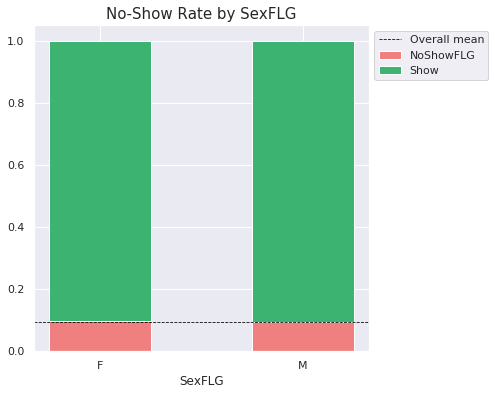

Means test p-value: 0.056
Cannot reject no-show rates are same for all groups


In [0]:
cat_var(df3, 'SexFLG')

Based on the analysis, we cannot say that no-show rates are different for men and women, which could indicate that the variable Gender is not a relevant one when predicting no-show. We shall include the variable as well because, interacting with others, Gender could gain relevance and became a good discriminator.

b) Age

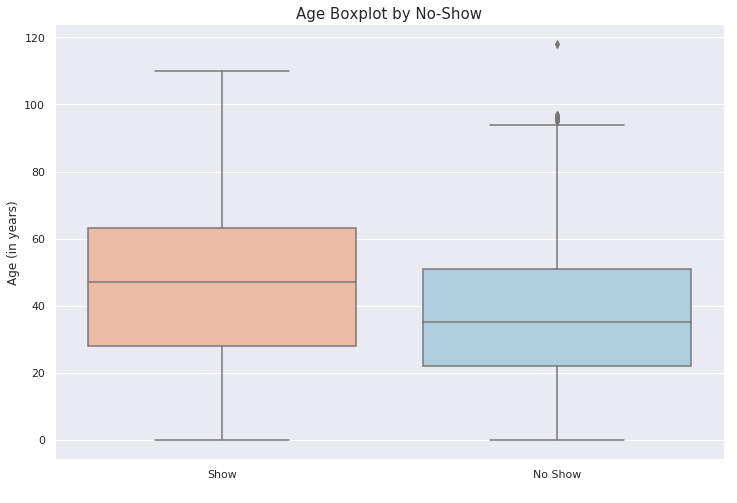

In [0]:
ax = sns.boxplot(x="NoShowFLG", y="AgeNBR",data= df3, palette = 'RdBu')
ax.set_xticklabels(['Show', 'No Show'])
plt.xlabel(' ')
plt.ylabel('Age (in years)')
plt.title('Age Boxplot by No-Show', fontsize = 15)
plt.gcf().set_size_inches(12, 8)
plt.show()

From the boxplot, we can see that people who don't show up to appointments tend to be younger than those who attend (based on quartiles).

In [0]:
print('Correlation with No-Show: %.3f' % ss.pointbiserialr(df3['NoShowFLG'], df3['AgeNBR'])[0])

Correlation with No-Show: -0.109


Correlation with no-show is very close to zero,which could indicate that the variable is not of much interest when predicting no-show.

c) InsuranceDSC

InsuranceDSC
Commercial    0.067083
Medicaid      0.161370
Medicare      0.055891
Self Pay      0.185075
Name: NoShowFLG, dtype: float64


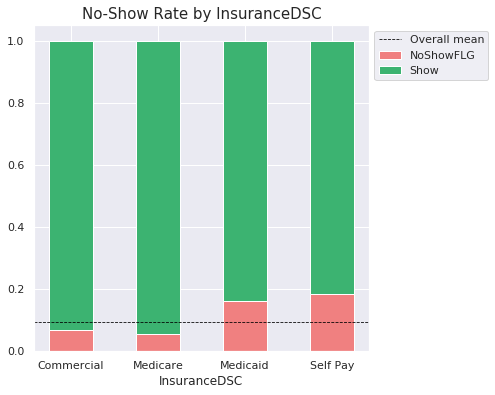

Means test p-value: 0.000
Reject null hypothesis: no-show rate is different for at least one group


In [0]:
cat_var(df3, 'InsuranceDSC')

From the above, we can assure that patients who are part of the Medicaid and self pay insurance  program have significantly higher no-show rates than peopleusing commercial and medicare. This could mean that the variable is very important for predicting no-show.

d) Clinic

ClinicNM
A    0.045355
B    0.121507
C    0.118508
D    0.066365
E    0.128149
Name: NoShowFLG, dtype: float64


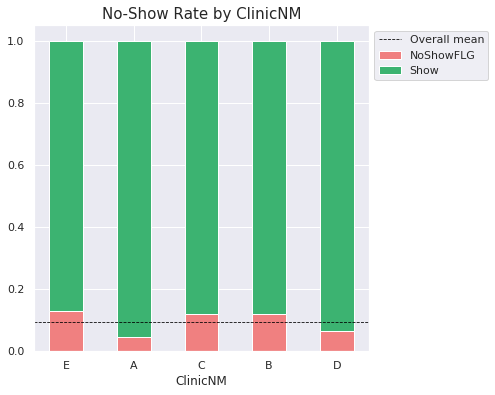

Means test p-value: 0.000
Reject null hypothesis: no-show rate is different for at least one group


In [0]:
cat_var(df3, 'ClinicNM')

As before, we can reject that people with various clinics present same no-show rates. This difference is significant, which indicates that the variable is of interest for predicting no-show. Clinic A and D tend to have lower no-show rates (maybe because they are in some kind of treatment...)

e) Appointment month

AppointmentMonthNBR
1     0.089944
2     0.084698
3     0.089242
4     0.093549
5     0.087766
6     0.097049
7     0.096531
8     0.100725
9     0.096753
10    0.102582
11    0.105943
12    0.102896
Name: NoShowFLG, dtype: float64


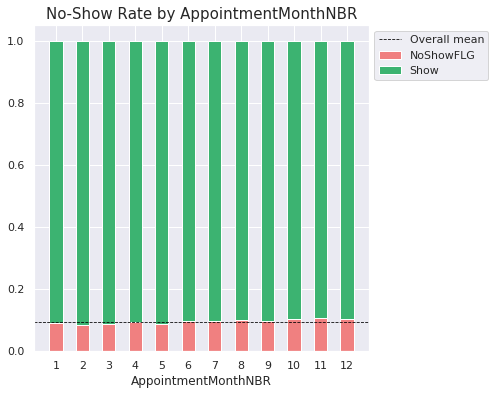

Means test p-value: 0.000
Reject null hypothesis: no-show rate is different for at least one group


In [0]:
cat_var(df3, 'AppointmentMonthNBR')

HispanicFLG
0    0.090218
1    0.132004
Name: NoShowFLG, dtype: float64


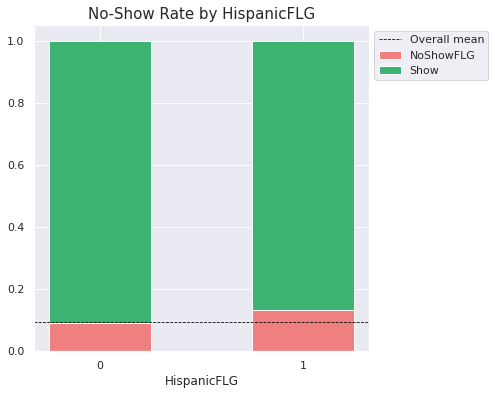

Means test p-value: 0.000
Reject null hypothesis: no-show rate is different for at least one group


In [0]:
cat_var(df3, 'HispanicFLG')

SingleFLG
0    0.069432
1    0.116751
Name: NoShowFLG, dtype: float64


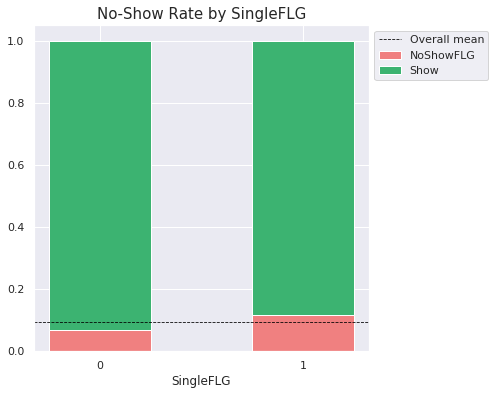

Means test p-value: 0.000
Reject null hypothesis: no-show rate is different for at least one group


In [0]:
cat_var(df3, 'SingleFLG')

LivesInApartmentFLG
0    0.089958
1    0.118849
Name: NoShowFLG, dtype: float64


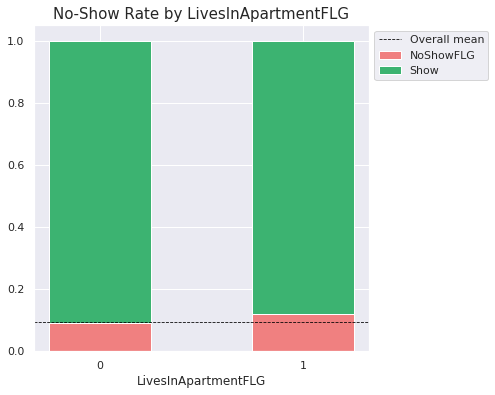

Means test p-value: 0.000
Reject null hypothesis: no-show rate is different for at least one group


In [0]:
cat_var(df3, 'LivesInApartmentFLG')

EmailFLG
0    0.112856
1    0.077738
Name: NoShowFLG, dtype: float64


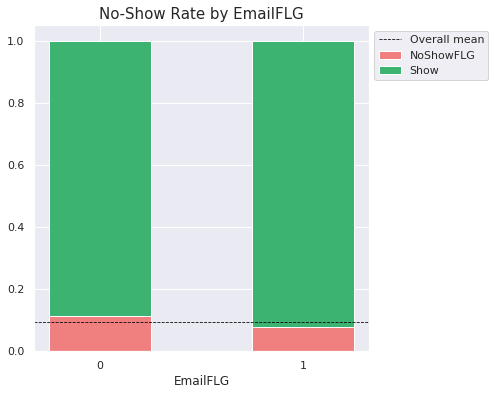

Means test p-value: 0.000
Reject null hypothesis: no-show rate is different for at least one group


In [0]:
cat_var(df3, 'EmailFLG')

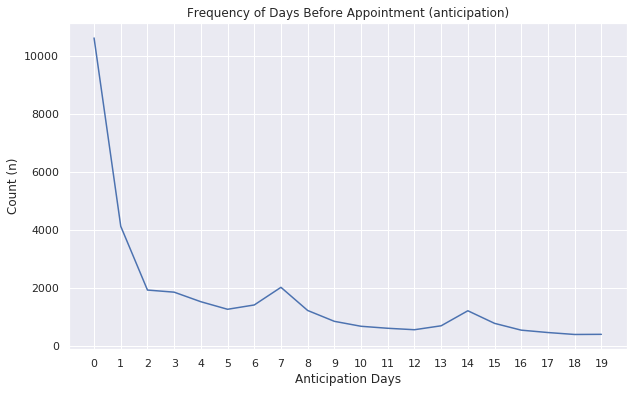

In [0]:
aux = df3.groupby(['DaysBeforeApp'])[['EmailFLG']].agg(['count','sum'])
aux.columns = ['count', 'EmailFLG']
aux[:20]['EmailFLG'].plot()
plt.gcf().set_size_inches(10, 6)
plt.xlabel('Anticipation Days')
plt.ylabel('Count (n)')
plt.title('Frequency of Days Before Appointment (anticipation)')
plt.xticks(range(0, 20))
plt.show()

HypertensionFLG
0    0.110144
1    0.069595
Name: NoShowFLG, dtype: float64


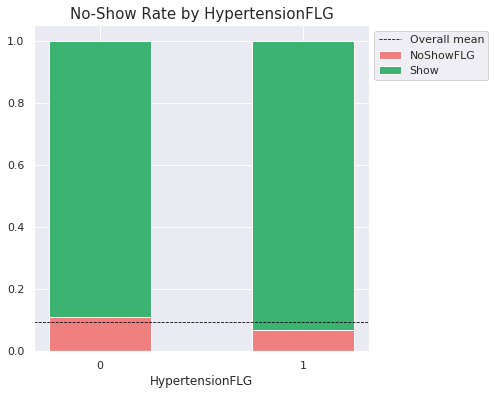

Means test p-value: 0.000
Reject null hypothesis: no-show rate is different for at least one group


In [0]:
cat_var(df3, 'HypertensionFLG')

AsthmaFLG
0    0.095044
1    0.101271
Name: NoShowFLG, dtype: float64


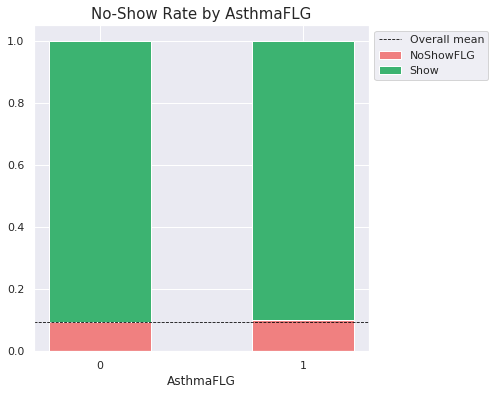

Means test p-value: 0.059
Cannot reject no-show rates are same for all groups


In [0]:
cat_var(df3, 'AsthmaFLG')

HeartDiseaseFLG
0    0.098536
1    0.071903
Name: NoShowFLG, dtype: float64


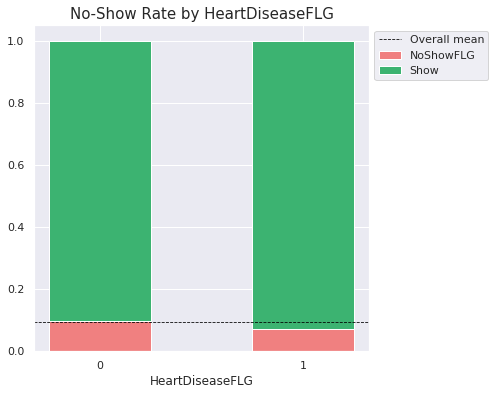

Means test p-value: 0.000
Reject null hypothesis: no-show rate is different for at least one group


In [0]:
cat_var(df3, 'HeartDiseaseFLG')

ObeseFLG
0    0.097687
1    0.089748
Name: NoShowFLG, dtype: float64


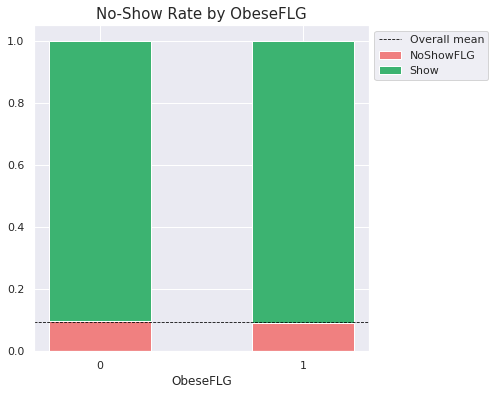

Means test p-value: 0.000
Reject null hypothesis: no-show rate is different for at least one group


In [0]:
cat_var(df3, 'ObeseFLG')

DiabetesFLG
0    0.095641
1    0.093690
Name: NoShowFLG, dtype: float64


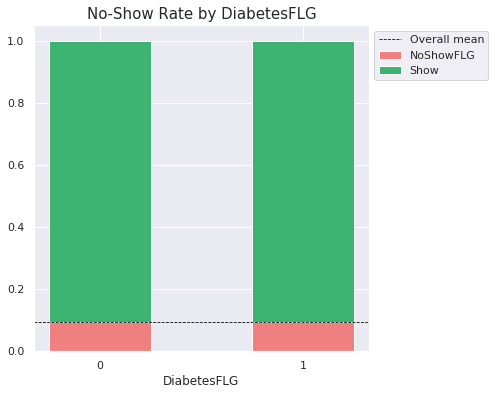

Means test p-value: 0.939
Cannot reject no-show rates are same for all groups


In [0]:
cat_var(df3, 'DiabetesFLG')

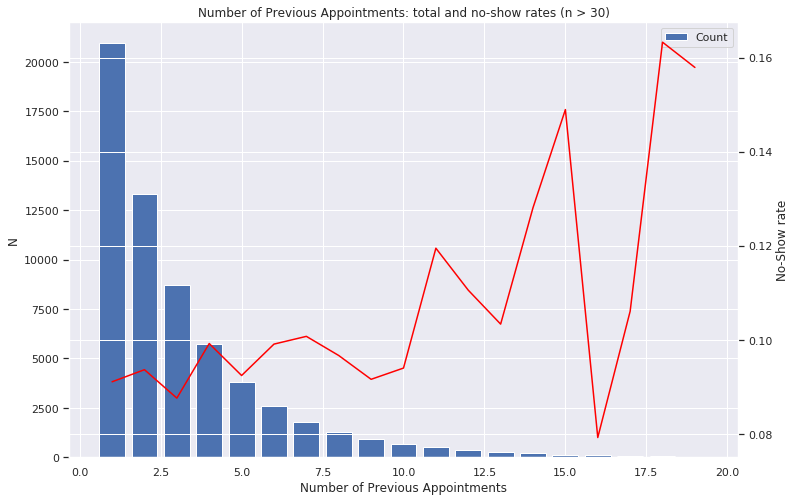

In [0]:
prevapp = df3.groupby(['PreviousApp'])[['NoShowFLG']].agg(['count', 'mean'])
prevapp.columns = ['count', 'NoShow_rate']
prevapp.reset_index(inplace = True)
import warnings
warnings.filterwarnings("ignore")
prevapp = prevapp[(prevapp['count'] > 30) & (prevapp['PreviousApp'] > 0)]
fig = plt.figure()

count = fig.add_subplot(111)
rate = count.twinx()

count.set_ylabel('N')
rate.set_ylabel('No-Show rate')

line1 = count.bar(prevapp['PreviousApp'], prevapp['count'])
line2 = rate.plot(prevapp['PreviousApp'], prevapp['NoShow_rate'], color = 'red', label = 'No-show Rate')
count.legend([line1, line2], ['Count', 'No-show Rate'])
plt.gcf().set_size_inches(12, 8)
count.set_xlabel('Number of Previous Appointments')
plt.title('Number of Previous Appointments: total and no-show rates (n > 30)')
plt.show()

We decided to eliminate from the plot appointments without previous appointments, as they are a much higher number than other categories and makes the plot more confusing. From the above, and considering we are only observing groups with more than 30 observations, we can say that no show rate are higher for patients with 18 AND above previous appointments and then the no show rates descend drastically (patients with lots of previous appointments are likely to be in a treatment as the data is condensed in 41 days).

In [0]:
print('Correlation with No-Show (all appointments): %.3f' % ss.pointbiserialr(df3['NoShowFLG'], df3['PreviousApp'])[0])
print('Correlation with No-Show (1 or more previous app): %.3f' % ss.pointbiserialr(df3[df3['PreviousApp'] > 0]['NoShowFLG'], df3[df3['PreviousApp'] > 0]['PreviousApp'])[0])

Correlation with No-Show (all appointments): 0.002
Correlation with No-Show (1 or more previous app): 0.011


The point biserial correlation is 0.002 and if we calculate the correlation without first-time-appointments, the value is closer to 1, indicating a stronger negative correlation.

i) PreviousNoShow

We will study no-show rates, grouping appointments by PreviousNoShow deciles.

In [0]:
prop_ns = df3.groupby(pd.cut(df3['PreviousNoShow'], np.arange(0, 1.05, 0.05), include_lowest = True))[['NoShowFLG']].mean()
prop_ns = prop_ns.reset_index()
prop_ns['middle'] = np.arange(0.025, 1.025, 0.05)
prop_ns.iloc[0,2] = 0
prop_ns.iloc[19,2] = 1

In [0]:
no_na = df3.dropna(subset = ['PreviousNoShow'])

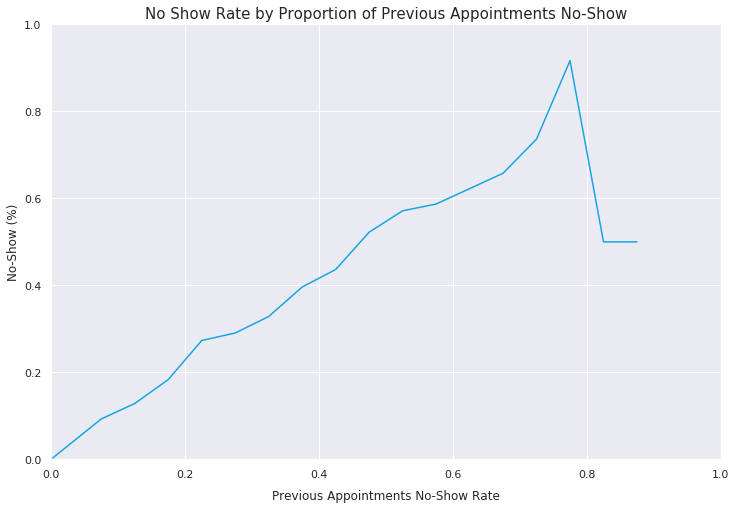

Correlation with No-Show: 0.771


In [0]:
prop_ns = prop_ns.drop([12], axis = 0)
plt.plot(prop_ns['middle'], prop_ns['NoShowFLG'], color = '#16a4e3')

plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('Previous Appointments No-Show Rate', labelpad=10)
plt.ylabel('No-Show (%)')
plt.grid(True)
plt.gcf().set_size_inches(12, 8)
plt.title('No Show Rate by Proportion of Previous Appointments No-Show', fontsize = 15)

plt.show()

print('Correlation with No-Show: %.3f' % ss.pointbiserialr(no_na['NoShowFLG'], no_na['PreviousNoShow'])[0])

As expected, previous patient behavior and no-show rate have an almost perfect linear relation. This supports the hypothesis that people tend to mantain certain behaviors in time. Moreover, the correlation between the variables is very close to 1, indicating a strong and positive correlation between previous no show and appointment noshow. For this, pevious behavior is a variable of interest for our model.

j) WeekdayScheduled

AppointmentWeekdayNBR
1    0.540541
2    0.101066
3    0.093653
4    0.092529
5    0.091292
6    0.100360
7    0.076923
Name: NoShowFLG, dtype: float64


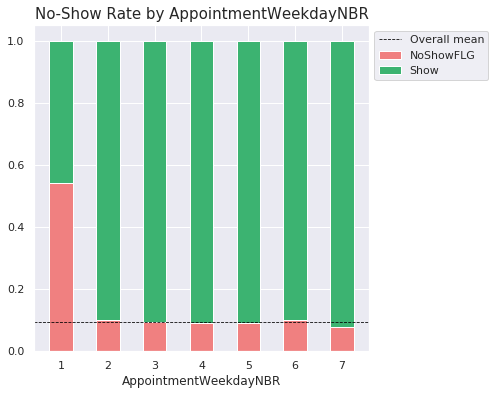

Means test p-value: 0.000
Reject null hypothesis: no-show rate is different for at least one group


In [0]:
cat_var(df3, 'AppointmentWeekdayNBR')

k) Days before CAT

DaysBeforeCat
0 days       0.031964
1-2 days     0.089847
3-7 days     0.108506
8-31 days    0.125864
> 31 days    0.121086
Name: NoShowFLG, dtype: float64


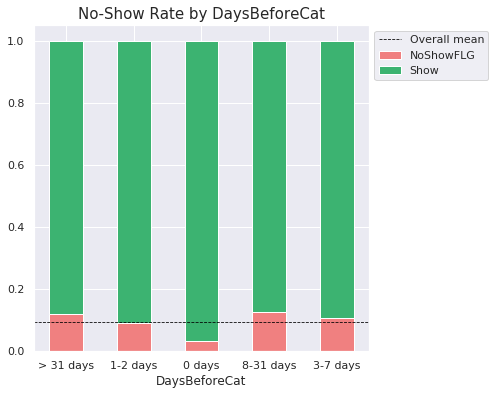

Means test p-value: 0.000
Reject null hypothesis: no-show rate is different for at least one group


In [0]:
cat_var(df3, 'DaysBeforeCat')

In [0]:
df3.head()

,Unnamed: 0,AppointmentID,PatientID,ClinicNM,AppointmentDTS,AppointmentMonthNBR,AppointmentWeekdayNBR,AppointmentHourNBR,AgeNBR,SexFLG,...,CancellationsNBR_Bin,AppttoCheckoutNBR_Bin,Latearrivals24NBR_Bin,PreviousApp,PreviousNoShow,AppointmentDTS2,WeekdayScheduled,PreviousDisease,DaysBeforeApp,DaysBeforeCat
0,1,21725,1,E,2018-04-10,4,3,17,50,F,...,"[0, 1]","(846, 897]","(1, 2]",0,NaN,04/10/18,2,0,32,> 31 days
1,2,11206,2,A,2018-02-07,2,4,10,80,M,...,"[0, 1]","(846, 897]","(1, 2]",1,0.0,02/07/18,3,1,2,1-2 days
2,3,12548,2,A,2018-02-08,2,5,16,80,M,...,"(1, 2]","(846, 897]","(1, 2]",2,0.0,02/08/18,4,1,0,0 days
3,4,12727,2,A,2018-03-08,3,5,15,80,M,...,"(1, 2]","(846, 897]","(1, 2]",3,0.0,03/08/18,4,1,28,8-31 days
4,5,86882,2,A,2018-11-09,11,6,16,80,M,...,"(1, 2]","(738, 846]","[0, 1]",0,NaN,11/09/18,5,1,0,0 days


In [0]:
df3.head()

,Unnamed: 0,AppointmentID,PatientID,ClinicNM,AppointmentDTS,AppointmentMonthNBR,AppointmentWeekdayNBR,AppointmentHourNBR,AgeNBR,SexFLG,...,CancellationsNBR_Bin,AppttoCheckoutNBR_Bin,Latearrivals24NBR_Bin,PreviousApp,PreviousNoShow,AppointmentDTS2,WeekdayScheduled,PreviousDisease,DaysBeforeApp,DaysBeforeCat
0,1,21725,1,E,2018-04-10,4,3,17,50,F,...,"[0, 1]","(846, 897]","(1, 2]",0,NaN,04/10/18,2,0,32,> 31 days
1,2,11206,2,A,2018-02-07,2,4,10,80,M,...,"[0, 1]","(846, 897]","(1, 2]",1,0.0,02/07/18,3,1,2,1-2 days
2,3,12548,2,A,2018-02-08,2,5,16,80,M,...,"(1, 2]","(846, 897]","(1, 2]",2,0.0,02/08/18,4,1,0,0 days
3,4,12727,2,A,2018-03-08,3,5,15,80,M,...,"(1, 2]","(846, 897]","(1, 2]",3,0.0,03/08/18,4,1,28,8-31 days
4,5,86882,2,A,2018-11-09,11,6,16,80,M,...,"(1, 2]","(738, 846]","[0, 1]",0,NaN,11/09/18,5,1,0,0 days


From the plot, it is clear that no-show rates are very different in each group: moreover, rates seem to be increasing as the number of days of anticipation is higher. For appointments scheduled in the same day (0 days of anticipation), no-show rates are dramatically lower and very close to zero (only 4.6%). This is clearly evidence enough to consider the variable as highly interesting and important to predict no-show.

In [0]:
df_done=df3

df_done.tail()

,Unnamed: 0,AppointmentID,PatientID,ClinicNM,AppointmentDTS,AppointmentMonthNBR,AppointmentWeekdayNBR,AppointmentHourNBR,AgeNBR,SexFLG,...,CancellationsNBR_Bin,AppttoCheckoutNBR_Bin,Latearrivals24NBR_Bin,PreviousApp,PreviousNoShow,AppointmentDTS2,WeekdayScheduled,PreviousDisease,DaysBeforeApp,DaysBeforeCat
95216,95217,20483,33472,A,2018-03-21,3,4,7,38,F,...,"(1, 2]","(738, 846]","[0, 1]",2,0.5,03/21/18,3,0,15,8-31 days
95217,95218,81514,33472,A,2018-10-19,10,6,8,38,F,...,"(2, 73]","(738, 846]","[0, 1]",1,1.0,10/19/18,5,0,1,1-2 days
95218,95219,81507,33472,A,2018-10-18,10,5,11,38,F,...,"(1, 2]","(738, 846]","[0, 1]",0,NaN,10/18/18,4,0,0,0 days
95219,95220,1763,33473,A,2018-06-05,6,3,8,40,M,...,"(73, 105]","(552, 738]","[0, 1]",1,0.0,06/05/18,2,1,182,> 31 days
95220,95221,46027,33473,A,2018-12-18,12,3,8,40,M,...,"(1, 2]","(738, 846]","[0, 1]",0,NaN,12/18/18,2,1,196,> 31 days


As XGBoost only receives numerical features, we must transform the categorical variables into dummy variables. We could change each variable to a number but this makes no sense as, for example, Mondays (1 in WeekdayAppointment) is not twice as Tuesdays (2 in WeekdayAppointment). Values must make sense. Given this, the transformations we will apply are:

Change Gender to "IsFemale" which takes the value 1 if Gender = F and 0 in other case
Change WeekdayScheduled to five variables: ScheduledMonday, ScheduledTuesday, ..., ScheduledFriday. Each variable is 1 if the appointment was scheduled in that particular day and 0 in other case. Same transformation will be apply to WeekdayAppointment (variables will be AppointmentMonday and so on)
Change DaysBeforeCat to five variables

In [0]:
# WeekdayAppointment to dummies
df_done = df_done.assign(AppointmentSunday = (df['AppointmentWeekdayNBR'] == 1)*1, 
                         AppointmentMonday = (df['AppointmentWeekdayNBR'] == 2)*1,
                         AppointmentTuesday = (df['AppointmentWeekdayNBR'] == 3)*1, 
                         AppointmentWednesday = (df['AppointmentWeekdayNBR'] == 4)*1,
                          AppointmentSaturday = (df['AppointmentWeekdayNBR'] == 7)*1,
                         AppointmentThursday = (df['AppointmentWeekdayNBR'] == 5)*1,
                         AppointmentFriday = (df['AppointmentWeekdayNBR'] == 6)*1)

# Gender to dummy 
df_done['IsFemale'] = (df_done['SexFLG'] == 'F')*1

# DaysBeforeCat to dummies
def ant_days(df):
    df.loc[:, 'Ant0Days'] = (df['DaysBeforeCat'] == '0 days')*1
    df.loc[:, 'Ant12Days'] = (df['DaysBeforeCat'] == '1-2 days')*1
    df.loc[:, 'Ant37Days'] = (df['DaysBeforeCat'] == '3-7 days')*1
    df.loc[:, 'Ant831Days'] = (df['DaysBeforeCat'] == '8-31 days')*1
    df.loc[:, 'Ant32Days'] = (df['DaysBeforeCat'] == '> 31 days')*1
    
ant_days(df_done)

In [0]:
df_done.columns

Index(['Unnamed: 0', 'AppointmentID', 'PatientID', 'ClinicNM',
       'AppointmentDTS', 'AppointmentMonthNBR', 'AppointmentWeekdayNBR',
       'AppointmentHourNBR', 'AgeNBR', 'SexFLG', 'HispanicFLG', 'SingleFLG',
       'LivesInApartmentFLG', 'EmailFLG', 'ApptLagNBR', 'InsuranceDSC',
       'HypertensionFLG', 'AsthmaFLG', 'HeartDiseaseFLG', 'ObeseFLG',
       'DiabetesFLG', 'Noshow24NBR', 'CancellationsNBR', 'Latearrivals24NBR',
       'CheckintoCheckoutNBR', 'AppttoCheckoutNBR', 'CheckintoApptNBR',
       'Arrived24NBR', 'Providers24CNT', 'ThatProvider24NBR',
       'NoshowRate24NBR', 'EdVisitsNBR', 'IpVisitsNBR', 'NoShowFLG',
       'CancelledLateFLG', 'NewPatient', 'Cost', 'Rand', 'Revenue', 'Profit',
       'Age_bin', 'ClinicNM_num', 'SexFLG_num', 'InsuranceDSC_num',
       'Noshow24NBR_Bin', 'CheckintoCheckoutNBR_Bin', 'CheckintoApptNBR_bin',
       'Arrived24NBR_bin', 'Providers24CNT_bin', 'ThatProvider24NBR_bin',
       'NoshowRate24NBR_bin', 'CancellationsNBR_Bin', 'AppttoCheck

In [0]:
# Clinic to dummies
def ClinicNM(df):
    df.loc[:, 'ClinicNM_A'] = (df['ClinicNM'] == 'A')*1
    df.loc[:, 'ClinicNM_B'] = (df['ClinicNM'] == 'B')*1
    df.loc[:, 'ClinicNM_C'] = (df['ClinicNM'] == 'C')*1
    df.loc[:, 'ClinicNM_D'] = (df['ClinicNM'] == 'D')*1
    df.loc[:, 'ClinicNM_E'] = (df['ClinicNM'] == 'E')*1
    
ClinicNM(df_done)

# InsuranceDSC to dummies
def InsuranceDSC(df):
    df.loc[:, 'DSCCommercial'] = (df['InsuranceDSC'] == 'Commercial')*1
    df.loc[:, 'DSCMedicare'] = (df['InsuranceDSC'] == 'Medicare')*1
    df.loc[:, 'DSCSelf_Pay'] = (df['InsuranceDSC'] == 'Self Pay')*1
    df.loc[:, 'DSCMedicaid'] = (df['InsuranceDSC'] == 'Medicaid')*1
       
InsuranceDSC(df_done)


In [0]:
df_done2=df_done
df_done=df_done2

In [0]:
df_done.dtypes

Unnamed: 0                        int64
AppointmentID                     int64
PatientID                         int64
ClinicNM                         object
AppointmentDTS           datetime64[ns]
AppointmentMonthNBR               int64
AppointmentWeekdayNBR             int64
AppointmentHourNBR                int64
AgeNBR                            int64
SexFLG                           object
HispanicFLG                       int64
SingleFLG                         int64
LivesInApartmentFLG               int64
EmailFLG                          int64
ApptLagNBR                        int64
InsuranceDSC                     object
HypertensionFLG                   int64
AsthmaFLG                         int64
HeartDiseaseFLG                   int64
ObeseFLG                          int64
DiabetesFLG                       int64
Noshow24NBR                       int64
CancellationsNBR                  int64
Latearrivals24NBR                 int64
CheckintoCheckoutNBR              int64


In [0]:
# Special thanks to https://www.kaggle.com/somang1418/tuning-hyperparameters-under-10-minutes-lgbm
def reduce_mem_usage(df, verbose=True):
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64) 
                else:
                  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                  elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                  else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [0]:
df_done.columns

Index(['Unnamed: 0', 'AppointmentID', 'PatientID', 'ClinicNM',
       'AppointmentDTS', 'AppointmentMonthNBR', 'AppointmentWeekdayNBR',
       'AppointmentHourNBR', 'AgeNBR', 'SexFLG', 'HispanicFLG', 'SingleFLG',
       'LivesInApartmentFLG', 'EmailFLG', 'ApptLagNBR', 'InsuranceDSC',
       'HypertensionFLG', 'AsthmaFLG', 'HeartDiseaseFLG', 'ObeseFLG',
       'DiabetesFLG', 'Noshow24NBR', 'CancellationsNBR', 'Latearrivals24NBR',
       'CheckintoCheckoutNBR', 'AppttoCheckoutNBR', 'CheckintoApptNBR',
       'Arrived24NBR', 'Providers24CNT', 'ThatProvider24NBR',
       'NoshowRate24NBR', 'EdVisitsNBR', 'IpVisitsNBR', 'NoShowFLG',
       'CancelledLateFLG', 'NewPatient', 'Cost', 'Rand', 'Revenue', 'Profit',
       'Age_bin', 'ClinicNM_num', 'SexFLG_num', 'InsuranceDSC_num',
       'Noshow24NBR_Bin', 'CheckintoCheckoutNBR_Bin', 'CheckintoApptNBR_bin',
       'Arrived24NBR_bin', 'Providers24CNT_bin', 'ThatProvider24NBR_bin',
       'NoshowRate24NBR_bin', 'CancellationsNBR_Bin', 'AppttoCheck

In [0]:
features = ['AppointmentMonthNBR',
       'AppointmentWeekdayNBR', 'AppointmentHourNBR', 'AgeNBR', 'HispanicFLG',
       'SingleFLG', 'LivesInApartmentFLG', 'EmailFLG', 'ApptLagNBR',
       'HypertensionFLG', 'HeartDiseaseFLG', 'ObeseFLG', 'Noshow24NBR',
       'CancellationsNBR', 'Latearrivals24NBR', 'CheckintoCheckoutNBR',
       'AppttoCheckoutNBR', 'CheckintoApptNBR', 'Arrived24NBR',
       'Providers24CNT', 'ThatProvider24NBR', 'NoshowRate24NBR', 'EdVisitsNBR',
       'IpVisitsNBR', 'CancelledLateFLG', 'NewPatient',
       'PreviousApp', 'PreviousNoShow', 'WeekdayScheduled', 'PreviousDisease',
       'DaysBeforeApp', 'AppointmentSunday', 'AppointmentMonday',
       'AppointmentTuesday', 'AppointmentWednesday', 'AppointmentSaturday',
       'AppointmentThursday', 'AppointmentFriday', 'IsFemale', 'Ant0Days',
       'Ant12Days', 'Ant37Days', 'Ant831Days', 'Ant32Days', 'ClinicNM_A',
       'ClinicNM_B', 'ClinicNM_C', 'ClinicNM_D', 'ClinicNM_E', 'DSCCommercial',
       'DSCMedicare', 'DSCSelf_Pay', 'DSCMedicaid']

label = 'NoShowFLG'

In [0]:
import numpy as np 
import pandas as pd 
from scipy import stats as ss
import statsmodels.api as sm
from sklearn import metrics
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from skopt import gp_minimize
from bayes_opt import BayesianOptimization
#import bayesian optimization
from skopt import gp_minimize

from skopt  import BayesSearchCV 
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
#pip install scikit-optimize
!pip install shap
import shap 

In [0]:

df_done = reduce_mem_usage(df_done)

X_train, X_test, y_train, y_test = train_test_split(df_done[features], df_done[label], test_size=0.3, random_state=6)
y_train = pd.DataFrame(y_train)
train = X_train.merge(y_train, left_index = True, right_index = True)
y_test = pd.DataFrame(y_test)
test = X_test.merge(y_test, left_index = True, right_index = True)

Mem. usage decreased to 20.80 Mb (0.0% reduction)


In [0]:
def param_opt_xgb(X, y, init_round=10, opt_round=10, n_folds=3, random_seed=6, output_process=False):
    # Prepare data
    dtest = xgb.DMatrix(X, y)

    def xgb_eval(learning_rate, n_estimators, max_depth, min_child_weight, gamma, subsample, colsample_bytree, scale_pos_weight):
        params = {'objective' : 'binary:logistic', 'nthread' : 4, 'seed' : random_seed, "silent":1}
        params['learning_rate'] = max(min(learning_rate, 1), 0)
        params['n_estimators'] = int(round(n_estimators))
        params['max_depth'] = int(round(max_depth))
        params['min_child_weight'] = int(round(min_child_weight))
        params['gamma'] = gamma
        params['subsample'] = max(min(subsample, 1), 0)
        params['colsample_bytree'] = max(min(colsample_bytree, 1), 0)
        params['scale_pos_weight'] = int(round(scale_pos_weight))
        cv_result = xgb.cv(params, dtest, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['auc'])
        
        
        return max(cv_result['train-auc-mean'])
    
    xgbBO = BayesianOptimization(xgb_eval, {'learning_rate': (0.01, 0.3),
                                                'n_estimators': (100, 200),
                                                'max_depth': (2, 7),
                                                'min_child_weight': (0, 7),
                                                'gamma': (0, 0.3),
                                                'subsample':(0.5,1),
                                                'colsample_bytree': (0.5, 1),
                                                'scale_pos_weight':(2,7)}, random_state=random_seed)
    xgbBO.maximize(init_points=init_round, n_iter=opt_round)

    model_aucpr=[]
    for model in range(len(xgbBO.res)):
        model_aucpr.append(xgbBO.res[model]['target'])

    # return best parameters
    return xgbBO.res[pd.Series(model_aucpr).idxmax()]['target'],xgbBO.res[pd.Series(model_aucpr).idxmax()]['params']

In [0]:
opt_params = param_opt_xgb(df_done[features], df_done[label])

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------
[0]	train-auc:0.892809+0.000345765	test-auc:0.892626+0.000779366
[9]	train-auc:0.932973+0.00358878	test-auc:0.932259+0.00298328
|  1        |  0.933    |  0.9464   |  0.09959  |  0.2482   |  2.208    |  0.7536   |  159.5    |  4.649    |  0.7094   |
[0]	train-auc:0.897703+0.0649485	test-auc:0.895355+0.0680459
[9]	train-auc:0.954216+0.000828263	test-auc:0.95162+0.000899979
|  2        |  0.9542   |  0.6677   |  0.1868   |  0.1371   |  5.679    |  3.626    |  157.9    |  5.227    |  0.9951   |
[0]	train-auc:0.897294+0.0664883	test-auc:0.893688+0.0710744
[9]	train-auc:0.956313+0.00101683	test-auc:0.953738+0.00106234
|  3        |  0.9563   |  0.9099   |  0.124    |  0.2641   |  6.119    |  0.3813   |  171.9    |  6.011    |  0.8682   |
[0]	train-auc

In [0]:
opt_params[1]['n_estimators'] = int(round(opt_params[1]['n_estimators']))
opt_params[1]['max_depth'] = int(round(opt_params[1]['max_depth']))
opt_params[1]['min_child_weight'] = int(round(opt_params[1]['min_child_weight']))
opt_params[1]['scale_pos_weight'] = int(round(opt_params[1]['scale_pos_weight']))
opt_params[1]['objective']='binary:logistic'
opt_params[1]['metric']='auc'
opt_params[1]['nthread']=4
opt_params[1]['seed']=6
opt_params=opt_params[1]
opt_params

{'colsample_bytree': 0.5268801739293981,
 'gamma': 0.1771347559403381,
 'learning_rate': 0.23591314513920617,
 'max_depth': 7,
 'metric': 'auc',
 'min_child_weight': 7,
 'n_estimators': 102,
 'nthread': 4,
 'objective': 'binary:logistic',
 'scale_pos_weight': 7,
 'seed': 6,
 'subsample': 0.8433427255394017}

In [0]:
def modelfit(alg, dtrain, dtest, predictors, target, eval_metric = True):
        #Fit the algorithm on the data
        if eval_metric:
            alg.fit(dtrain[predictors], dtrain[target].values.ravel(), eval_metric = ['auc'])
        else: 
            alg.fit(dtrain[predictors], dtrain[target].values.ravel())
            
        #Predict training set:
        dtrain_predictions = alg.predict(dtrain[predictors])
        dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
        #Predict test set:
        dtest_predictions = alg.predict(dtest[predictors])
        dtest_predprob = alg.predict_proba(dtest[predictors])[:,1]
            
        #Print model report:
        print( " Model Report")
        print("Accuracy Train: %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
        print("Recall Train: %.4g" % metrics.recall_score(dtrain[target].values, dtrain_predictions))
        print("Accuracy Test: %.4g" % metrics.accuracy_score(dtest[target].values, dtest_predictions))
        print("Recall Test: %.4g" % metrics.recall_score(dtest[target].values, dtest_predictions))
        print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob))
        

In [0]:
xgb1 = XGBClassifier(
        learning_rate =opt_params['learning_rate'],
        n_estimators=opt_params['n_estimators'],
        max_depth=6,
        min_child_weight=opt_params['min_child_weight'],
        gamma=opt_params['gamma'],
        subsample=opt_params['subsample'],
        colsample_bytree=opt_params['colsample_bytree'],
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=opt_params['scale_pos_weight'],
        seed=6)

modelfit(xgb1, train, test, features, target = label)

 Model Report
Accuracy Train: 0.9178
Recall Train: 0.9441
Accuracy Test: 0.8989
Recall Test: 0.8304
AUC Score (Train): 0.980017


In [0]:
print('Accuracy naive model: {:1.4f}'.format(1-test[label].mean()))

Accuracy naive model: 0.9042


We've gained 2% from the naive model, not so much.

For this reason, we'll try with Logistic Regression (back to my dear glms) and check accuracy for train and test datasets. First, we will study correlations:

In [0]:
df_done.columns

Index(['Unnamed: 0', 'AppointmentID', 'PatientID', 'ClinicNM',
       'AppointmentDTS', 'AppointmentMonthNBR', 'AppointmentWeekdayNBR',
       'AppointmentHourNBR', 'AgeNBR', 'SexFLG', 'HispanicFLG', 'SingleFLG',
       'LivesInApartmentFLG', 'EmailFLG', 'ApptLagNBR', 'InsuranceDSC',
       'HypertensionFLG', 'AsthmaFLG', 'HeartDiseaseFLG', 'ObeseFLG',
       'DiabetesFLG', 'Noshow24NBR', 'CancellationsNBR', 'Latearrivals24NBR',
       'CheckintoCheckoutNBR', 'AppttoCheckoutNBR', 'CheckintoApptNBR',
       'Arrived24NBR', 'Providers24CNT', 'ThatProvider24NBR',
       'NoshowRate24NBR', 'EdVisitsNBR', 'IpVisitsNBR', 'NoShowFLG',
       'CancelledLateFLG', 'NewPatient', 'Cost', 'Rand', 'Revenue', 'Profit',
       'Age_bin', 'ClinicNM_num', 'SexFLG_num', 'InsuranceDSC_num',
       'Noshow24NBR_Bin', 'CheckintoCheckoutNBR_Bin', 'CheckintoApptNBR_bin',
       'Arrived24NBR_bin', 'Providers24CNT_bin', 'ThatProvider24NBR_bin',
       'NoshowRate24NBR_bin', 'CancellationsNBR_Bin', 'AppttoCheck

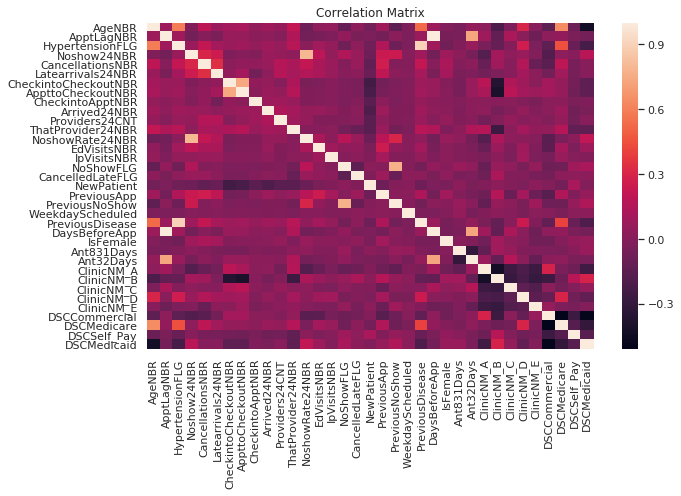

,AgeNBR,ApptLagNBR,HypertensionFLG,Noshow24NBR,CancellationsNBR,Latearrivals24NBR,CheckintoCheckoutNBR,AppttoCheckoutNBR,CheckintoApptNBR,Arrived24NBR,...,Ant32Days,ClinicNM_A,ClinicNM_B,ClinicNM_C,ClinicNM_D,ClinicNM_E,DSCCommercial,DSCMedicare,DSCSelf_Pay,DSCMedicaid
AgeNBR,1.000000,0.078076,0.587933,-0.013576,0.198770,0.071979,0.109558,0.122254,0.048247,0.091780,...,0.049802,0.031724,-0.205502,-0.027804,0.300325,0.005753,-0.139850,0.643542,-0.092846,-0.427594
ApptLagNBR,0.078076,1.000000,0.084989,-0.060661,0.004148,-0.034814,0.067094,0.060251,0.027778,0.030508,...,0.729768,0.089992,-0.124579,0.128726,0.010836,-0.087212,0.029668,0.042403,-0.032188,-0.057238
HypertensionFLG,0.587933,0.084989,1.000000,0.073388,0.216079,0.099760,0.074145,0.090263,0.046383,0.089657,...,0.061767,-0.037243,-0.108732,-0.002313,0.261434,-0.026285,-0.138476,0.447257,-0.097994,-0.226694
Noshow24NBR,-0.013576,-0.060661,0.073388,1.000000,0.302115,0.249358,-0.019448,0.004465,-0.008088,0.074106,...,-0.051966,-0.176514,0.110722,0.029826,0.068160,-0.009269,-0.181405,0.030908,0.008026,0.177849
CancellationsNBR,0.198770,0.004148,0.216079,0.302115,1.000000,0.337865,0.019616,0.042172,0.045821,0.064385,...,0.017960,-0.105242,0.084242,0.002249,0.152124,-0.104067,-0.150242,0.194973,-0.043639,0.008005
Latearrivals24NBR,0.071979,-0.034814,0.099760,0.249358,0.337865,1.000000,0.046093,0.099239,-0.063507,0.030504,...,-0.022286,-0.061435,-0.025715,0.006064,0.103223,0.018129,-0.061801,0.096583,-0.048791,0.006654
CheckintoCheckoutNBR,0.109558,0.067094,0.074145,-0.019448,0.019616,0.046093,1.000000,0.742917,0.042694,0.053845,...,0.064459,0.185411,-0.364457,0.147973,0.092400,0.015774,0.106602,0.048736,-0.055248,-0.139656
AppttoCheckoutNBR,0.122254,0.060251,0.090263,0.004465,0.042172,0.099239,0.742917,1.000000,0.019799,0.074593,...,0.063714,0.128239,-0.397350,0.186520,0.109105,0.076197,0.099998,0.057461,-0.067390,-0.132836
CheckintoApptNBR,0.048247,0.027778,0.046383,-0.008088,0.045821,-0.063507,0.042694,0.019799,1.000000,0.080441,...,0.027134,0.013068,0.007319,0.014633,-0.011312,-0.030521,0.013273,0.027127,-0.033391,-0.021579
Arrived24NBR,0.091780,0.030508,0.089657,0.074106,0.064385,0.030504,0.053845,0.074593,0.080441,1.000000,...,0.022911,0.030969,-0.052233,-0.007108,0.050219,-0.005340,0.010987,0.071219,-0.075704,-0.036200


In [0]:
features0 = ['AgeNBR',  'ApptLagNBR',
       'HypertensionFLG', 'Noshow24NBR',
       'CancellationsNBR', 'Latearrivals24NBR', 'CheckintoCheckoutNBR',
       'AppttoCheckoutNBR', 'CheckintoApptNBR', 'Arrived24NBR',
       'Providers24CNT', 'ThatProvider24NBR', 'NoshowRate24NBR', 'EdVisitsNBR',
       'IpVisitsNBR', 'NoShowFLG', 'CancelledLateFLG', 'NewPatient',
       'PreviousApp', 'PreviousNoShow', 'WeekdayScheduled', 'PreviousDisease',
       'DaysBeforeApp',  'IsFemale', 'Ant831Days', 'Ant32Days', 'ClinicNM_A',
       'ClinicNM_B', 'ClinicNM_C', 'ClinicNM_D', 'ClinicNM_E', 'DSCCommercial',
       'DSCMedicare', 'DSCSelf_Pay', 'DSCMedicaid']
corr = df_done[features0].corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.title('Correlation Matrix')
plt.gcf().set_size_inches(10, 6)
plt.show()

corr

From the matrix, we can see that Hipertension is highly correlated with PreviousDisease, Age and Diabetes. Also, Age is highly correlated with PreviousDisease. For this reason, we will eliminate PreviousDisease from the analysis but shall keep the others (correlation is high but not extreme).

Previously, NaN values didn't matter, as XGBoost learned from the data which path was the best. As now observations with missing values can not be used, we will change the variable PreviousNoShow as MissedAppointments : number of previous appointments with no-show.

Also, we will scale the data so all values are between 1 and 0.

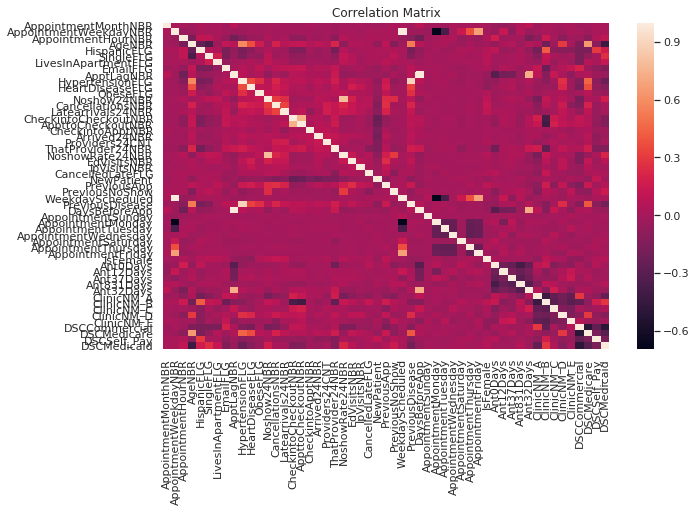

,AppointmentMonthNBR,AppointmentWeekdayNBR,AppointmentHourNBR,AgeNBR,HispanicFLG,SingleFLG,LivesInApartmentFLG,EmailFLG,ApptLagNBR,HypertensionFLG,...,Ant32Days,ClinicNM_A,ClinicNM_B,ClinicNM_C,ClinicNM_D,ClinicNM_E,DSCCommercial,DSCMedicare,DSCSelf_Pay,DSCMedicaid
AppointmentMonthNBR,1.000000,0.022109,0.004862,-0.014247,0.026752,0.003322,0.008807,-0.021491,0.073841,-0.012622,...,0.095913,-0.031596,0.022479,0.004278,-0.010789,0.014690,-0.019729,-0.002530,0.009811,0.019529
AppointmentWeekdayNBR,0.022109,1.000000,-0.046610,-0.029996,0.019057,0.005820,0.014906,-0.008308,-0.029727,-0.027530,...,-0.046476,-0.014004,0.024015,-0.000645,-0.030017,0.011649,0.004232,-0.030580,0.014716,0.016494
AppointmentHourNBR,0.004862,-0.046610,1.000000,-0.174828,0.105155,0.105438,0.021045,-0.063123,-0.204418,-0.122382,...,-0.162008,-0.084119,0.148948,0.005814,-0.095840,-0.014198,-0.025503,-0.099952,0.045918,0.101818
AgeNBR,-0.014247,-0.029996,-0.174828,1.000000,-0.255048,-0.358741,-0.031167,0.111290,0.078076,0.587933,...,0.049802,0.031724,-0.205502,-0.027804,0.300325,0.005753,-0.139850,0.643542,-0.092846,-0.427594
HispanicFLG,0.026752,0.019057,0.105155,-0.255048,1.000000,0.058754,0.031849,-0.162143,-0.069802,-0.173441,...,-0.061417,-0.197272,0.419541,-0.097940,-0.108653,-0.107304,-0.161682,-0.167077,0.303703,0.163844
SingleFLG,0.003322,0.005820,0.105438,-0.358741,0.058754,1.000000,0.165769,-0.162859,-0.047972,-0.153532,...,-0.028855,-0.124008,0.116571,0.022072,-0.026567,0.003573,-0.160520,-0.066178,0.005123,0.253567
LivesInApartmentFLG,0.008807,0.014906,0.021045,-0.031167,0.031849,0.165769,1.000000,-0.054672,-0.019401,0.000443,...,-0.021649,-0.048244,0.095488,-0.044105,0.018045,-0.033643,-0.170148,0.062957,0.018824,0.125024
EmailFLG,-0.021491,-0.008308,-0.063123,0.111290,-0.162143,-0.162859,-0.054672,1.000000,0.013172,0.065974,...,0.008838,0.119146,-0.228428,-0.000629,0.047675,0.106438,0.194714,-0.032686,-0.080151,-0.145038
ApptLagNBR,0.073841,-0.029727,-0.204418,0.078076,-0.069802,-0.047972,-0.019401,0.013172,1.000000,0.084989,...,0.729768,0.089992,-0.124579,0.128726,0.010836,-0.087212,0.029668,0.042403,-0.032188,-0.057238
HypertensionFLG,-0.012622,-0.027530,-0.122382,0.587933,-0.173441,-0.153532,0.000443,0.065974,0.084989,1.000000,...,0.061767,-0.037243,-0.108732,-0.002313,0.261434,-0.026285,-0.138476,0.447257,-0.097994,-0.226694


In [0]:
corr = df_done[features].corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.title('Correlation Matrix')
plt.gcf().set_size_inches(10, 6)
plt.show()

corr

Logistic regression

In [0]:
df_done.loc[:, 'MissedAppointments'] = df_done.sort_values(['AppointmentWeekdayNBR']).groupby(['PatientID'])['NoShowFLG'].cumsum()

In [0]:
features0 = ['AppointmentMonthNBR','MissedAppointments',
       'AppointmentWeekdayNBR', 'AppointmentHourNBR', 'AgeNBR', 'HispanicFLG',
       'SingleFLG', 'LivesInApartmentFLG', 'EmailFLG', 'ApptLagNBR',
       'HypertensionFLG', 'HeartDiseaseFLG', 'ObeseFLG', 'Noshow24NBR',
       'CancellationsNBR', 'Latearrivals24NBR', 'CheckintoCheckoutNBR',
       'AppttoCheckoutNBR', 'CheckintoApptNBR', 
       'Providers24CNT',  'EdVisitsNBR',
       'IpVisitsNBR', 'CancelledLateFLG', 'NewPatient',
       'PreviousApp',  'WeekdayScheduled', 'PreviousDisease',
       'DaysBeforeApp', 'AppointmentSunday', 'AppointmentMonday',
       'AppointmentTuesday', 'AppointmentWednesday', 'AppointmentSaturday',
       'AppointmentThursday', 'AppointmentFriday', 'IsFemale', 'Ant0Days',
       'Ant12Days', 'Ant37Days', 'Ant831Days', 'Ant32Days', 'ClinicNM_A',
       'ClinicNM_B', 'ClinicNM_C', 'ClinicNM_D', 'ClinicNM_E', 'DSCCommercial',
       'DSCMedicare', 'DSCSelf_Pay', 'DSCMedicaid']

In [0]:
scaler = StandardScaler().fit(df_done[features0])
df_rescaled = scaler.transform(df_done[features0])

X_train, X_test, y_train, y_test = train_test_split(df_done[features0], df_done[label], test_size=0.3, random_state=6)
y_train = pd.DataFrame(y_train)
train = X_train.merge(y_train, left_index = True, right_index = True)
y_test = pd.DataFrame(y_test)
test = X_test.merge(y_test, left_index = True, right_index = True)

In [0]:
logit = LogisticRegression(class_weight = 'balanced', solver = 'liblinear')
modelfit(logit, train, test, features0, label, eval_metric = False)

 Model Report
Accuracy Train: 0.9178
Recall Train: 0.9863
Accuracy Test: 0.9197
Recall Test: 0.9854
AUC Score (Train): 0.967270


Accuracy is worst than XGBoost ! Compared to naive model, 

We will train a Decision Tree, just to check how does this model compare to the two we already have.

In [0]:
tree = DecisionTreeClassifier(max_depth=12, random_state=0)
modelfit(tree, train, test,features0, label, eval_metric=False)

 Model Report
Accuracy Train: 0.9599
Recall Train: 0.7777
Accuracy Test: 0.9409
Recall Test: 0.6849
AUC Score (Train): 0.987762


Finally, we will train a Random Forest: as one decision tree performed better, maybe several decision trees perform best.

In [0]:
rf = RandomForestClassifier(random_state = 0, class_weight = 'balanced')
modelfit(rf, train, test,features0, label, eval_metric=False)

 Model Report
Accuracy Train: 0.9968
Recall Train: 0.9694
Accuracy Test: 0.937
Recall Test: 0.5267
AUC Score (Train): 0.999909


The best so far !! We will use this model to study variable importance and predictive power.

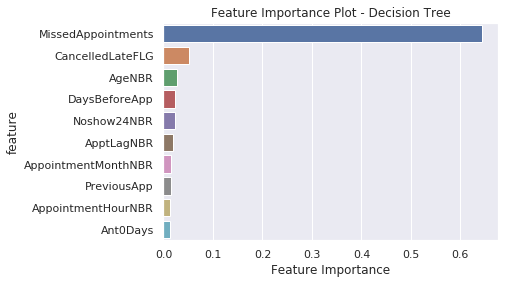

In [0]:
feature_importance = pd.DataFrame({'feature' : features0,
                                   'importances' : rf.feature_importances_})
ordered = feature_importance.sort_values(['importances'], ascending = False)
best = ordered[:10]
sns.barplot(x = 'importances', y = 'feature', data = best)
plt.xlabel('Feature Importance')
plt.title('Feature Importance Plot - Decision Tree')
plt.show()

We can see that the most important feature is "missed appointments", "cancelled late" and "checkintocheck outnbr". Two of these three variables make reference to the patient's past behavior, which supports the hypothesis of patients repeating behaviors over time. As we have little history this is not enough to say that patients will always behave the same way but for this period of time this is true.

For better understanding, we will use SHAP Values. DanB made a marvelous job explaining advanced uses of SHAP Values (see here) and for better understanding you can check this medium post .

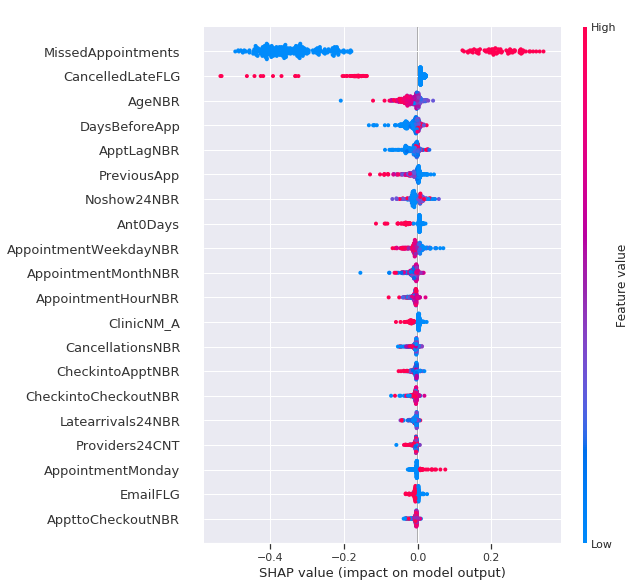

In [0]:
sample = X_test.sample(300)
shap.initjs()
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(sample[features0])
shap.summary_plot(shap_values[1], sample[features0])

From SHAP Values, we can see that the most important variable is "MissedAppointments" (as mentioned before). In fact, this variable is able to divide the data, impact negatively on the model output for low values of MissedApointments and impact positively for higher values of missed appointments (which makes sense).

Another variable to watch is "Ant0days". As a reminder, this variable takes the value 1 when the appointment was scheduled with less than a day of anticipation and 0 for any other case (which means that low values of the variable correspond to appointments scheduled with at least one day of anticipation, while high values are for appointments with less than a day of anticipation). In the plot above, we can see there's a clear separation for Ant0days: appointments with value 1 lower the chanses of noshow, while appointments with value 0 receive a positive impact (elevates chances of no-show, also makes sense).

Now we shall study how the model clasificates in general:

In [0]:
df_done.head()

,Unnamed: 0,AppointmentID,PatientID,ClinicNM,AppointmentDTS,AppointmentMonthNBR,AppointmentWeekdayNBR,AppointmentHourNBR,AgeNBR,SexFLG,...,ClinicNM_A,ClinicNM_B,ClinicNM_C,ClinicNM_D,ClinicNM_E,DSCCommercial,DSCMedicare,DSCSelf_Pay,DSCMedicaid,MissedAppointments
0,1,21725,1,E,2018-04-10,4,3,17,50,F,...,0,0,0,0,1,1,0,0,0,1
1,2,11206,2,A,2018-02-07,2,4,10,80,M,...,1,0,0,0,0,0,1,0,0,0
2,3,12548,2,A,2018-02-08,2,5,16,80,M,...,1,0,0,0,0,0,1,0,0,0
3,4,12727,2,A,2018-03-08,3,5,15,80,M,...,1,0,0,0,0,0,1,0,0,0
4,5,86882,2,A,2018-11-09,11,6,16,80,M,...,1,0,0,0,0,0,1,0,0,0


In [0]:
from google.colab import files

#check for nulls :pd.isnull(df_done).sum() > 0
# e.g. save pandas output as csv
df_done.to_csv('df_done.csv')
files.download('df_done.csv')

True Positive Rate (recall): 0.910
Accuracy: 0.912


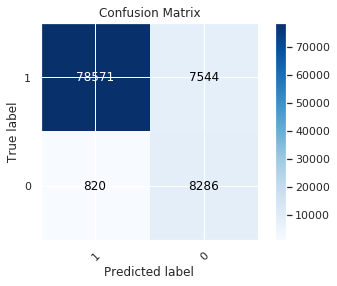

In [0]:
#xgboost predictions
df_done['preds'] = xgb1.predict(df_done[features])
cm = metrics.confusion_matrix(df_done['NoShowFLG'], (df_done['preds'] > 0.5)*1)
normalize = False 

fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=['1', '0'], yticklabels=['1', '0'],
       title='Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
fmt = '.2f' if normalize else 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

ax

print('True Positive Rate (recall): {:1.3f}'.format(metrics.recall_score(df_done['NoShowFLG'], (df_done['preds'] > 0.5)*1)))
print('Accuracy: {:1.3f}'.format(metrics.accuracy_score(df_done['NoShowFLG'], (df_done['preds'] > 0.5)*1)))

True Positive Rate (recall): 0.750
Accuracy: 0.954


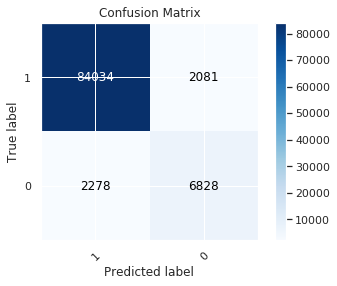

In [0]:
#tree predictions
df_done['preds'] = tree.predict(df_done[features0])
cm = metrics.confusion_matrix(df_done['NoShowFLG'], (df_done['preds'] > 0.5)*1)
normalize = False 

fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=['1', '0'], yticklabels=['1', '0'],
       title='Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
   
    # Loop over data dimensions and create text annotations.
fmt = '.2f' if normalize else 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

ax
print('True Positive Rate (recall): {:1.3f}'.format(metrics.recall_score(df_done['NoShowFLG'], (df_done['preds'] > 0.5)*1)))
print('Accuracy: {:1.3f}'.format(metrics.accuracy_score(df_done['NoShowFLG'], (df_done['preds'] > 0.5)*1)))

True Positive Rate (recall): 0.986
Accuracy: 0.918


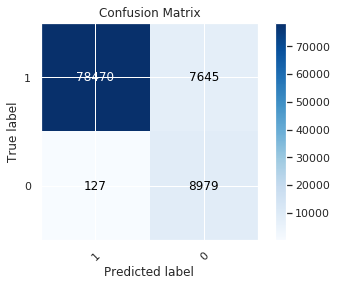

In [0]:
#logistic regression predictions
df_done['preds'] = logit.predict(df_done[features0])
cm = metrics.confusion_matrix(df_done['NoShowFLG'], (df_done['preds'] > 0.5)*1)
normalize = False 

fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=['1', '0'], yticklabels=['1', '0'],
       title='Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
   
    # Loop over data dimensions and create text annotations.
fmt = '.2f' if normalize else 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

ax

print('True Positive Rate (recall): {:1.3f}'.format(metrics.recall_score(df_done['NoShowFLG'], (df_done['preds'] > 0.5)*1)))
print('Accuracy: {:1.3f}'.format(metrics.accuracy_score(df_done['NoShowFLG'], (df_done['preds'] > 0.5)*1)))

From the above, we can see how xgboost classifies correctly or incorrectly each appointment. The model is able to correctly predict more than 90% of No-Shows, which is very high. At the same time, more than 91% of cases are correctly labeled so the hospital should expect less than 9% of error ( low)

True Positive Rate (recall): 0.836
Accuracy: 0.979


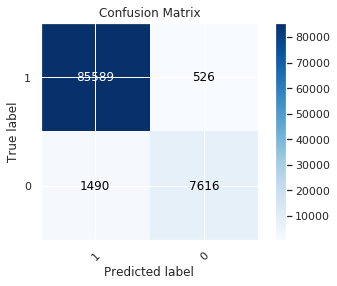

In [0]:
#randomforest predictions
df_done['preds'] = rf.predict(df_done[features0])
cm = metrics.confusion_matrix(df_done['NoShowFLG'], (df_done['preds'] > 0.5)*1)
normalize = False 

fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=['1', '0'], yticklabels=['1', '0'],
       title='Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
fmt = '.2f' if normalize else 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

ax
print('True Positive Rate (recall): {:1.3f}'.format(metrics.recall_score(df_done['NoShowFLG'], (df_done['preds'] > 0.5)*1)))
print('Accuracy: {:1.3f}'.format(metrics.accuracy_score(df_done['NoShowFLG'], (df_done['preds'] > 0.5)*1)))

From the above, we can see how the random forest classifies correctly or incorrectly each appointment. The model is able to correctly predict more than 82% of No-Shows, which is very high. At the same time, more than 97% of cases are correctly labeled so the hospital should expect less than 3% of error (very very low).

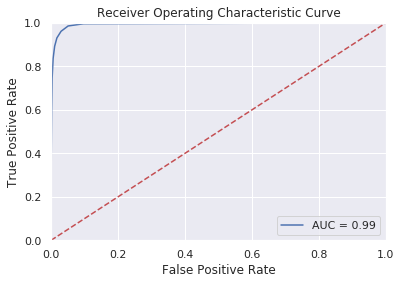

In [0]:
# ROC Curve 
probs = rf.predict_proba(df_done[features0])[:,1]

fpr, tpr, threshold = metrics.roc_curve(df_done['NoShowFLG'], probs)
roc_auc = metrics.auc(fpr, tpr)


plt.title('Receiver Operating Characteristic Curve')
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

ROC Curve is almost perfect ! We have very early return (high true positive rate with low false positive rate, the ideal) which indicates that the model is very good.

Sometimes accuracy this high (over 90%) makes one wonder if we are overfitting data and that if we change the sample, the model will lower it's performance. However we must keep in mind that, because we have a very unbalanced data set, the naive model already has accuracy score near 80%, so this should be our point of start. In most "academic" excercises, data is perfectly balanced (50-50) so achieving accuracy above 90% is considered at least suspicious.But for unbalanced data, this doesn't apply (actually, no model should give accuracy below the naive model).

